### Source and Flare Detection for Poisson Noise Data


$P_{poi}(M|B)=\frac{B^{M}e^{-B}}{M!}$

our models for the two hypotheses are:

background only:

$H_{0} : M(q) = poi(B)$

background + signal:

$H_{1}(q_{0},F) : M(q) = poi(B+FPT)$

where F is some constant number (the flux), P is a point spread function in (x,y) and T is some "flare function" of time. the integral of PT over (x,y,t) is 1. and F controls the overall normalisation of the signal strength.

our test statistic, is

$S = \sum_{q}M_{q}log\left(1+\frac{FPT}{B}\right)$

we need to find the S threshold, such that the integral of the PDF of S under the background only hypotehsis, from that threshold to S = $\infty$ is equal to some given $\beta$ (false alarm probability).

now, the PDF of S depends on F (the flux). 
if our data was exactly the signal (FPT) but with the background B subtracted, and we were to multiply it by the filter, the value of S we would get would be:

$S = (F-B)\sum_{q}(PT)_{(q)}log\left(1+\frac{FPT}{B}\right)$

we are sensative only to a flux which would make this value of S at least equal to the threshold S required for false alarm rate $\beta$.

so we must solve numerically the system of two equations:

$\int_{S_{threshold}}^{\infty}PDF_{(S)}dS=\beta$

$S_{threshold} = (F_{threshold}-B)\sum_{q}(PT)_{(q)}log\left(1+\frac{F_{threshold}PT}{B}\right)$

we can start from an intial guess for $F_{threshold}$ as the value of flux that would solve the equation:

$1-\beta = \int_{0}^{F_{threshold}}Pois(f| B\cdot4\pi r^{2} )$

where r is the typical radius of the signal template psf

in order to find the threshold S for a given threshold flux, we need to caclulate the PDF of S, which we can do numerically by generating "background only" monte carlo samples, calculating the value of S in each pixel, and making a histogram of S.

outline:

1. create a template with norm 1.
2. create filter (according to above formula)
3. start with intial guess of threshold flux
4. calculate flux normalisation: $Flux_{norm} = \sum_{q}(PT)_{(q)}log\left(1+\frac{FPT}{B}\right)$
5. generate background only samples
6. collect values of test statistic S (the pixels in the cross correlation of the filter with the images)
7. find the threshold of S such that the false positive rate is some value $\beta$
8. set the next iteration of flux threshold to $F_{threshold} = \frac{S_{threshold}}{Flux_{norm}}+B$
9. go back to 4 and repeat until $F_{threshold}$ has converged
10. repeat for a number of different backgrounds, and for different values of PSF width, and for different decay times.
11. generate images with template inside them, with a varity of flux values
12. use optimal filter to cross correlate with images. for each value of flux, calculate the completeness (the fraction of signals for which the threshold value of S was crossed)
13. repeat also for the "standard" matched filter, where you cross correlate the image only with the template itself.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal,sparse
from scipy.stats import poisson

In [2]:
def make2Dsliceplot(ar3D,projax,val,title,colorMap):
    if projax=='x': ar2D=ar3D[val,:,:]
    if projax=='y': ar2D=ar3D[:,val,:]
    if projax=='z': ar2D=ar3D[:,:,val]
#     fig=plt.figure()
#     ax=fig.add_subplot(111)
    plt.imshow(ar2D, cmap=colorMap)
    plt.colorbar(orientation='vertical')
    plt.title("%s for %s=%s"%(title,projax,val))
    plt.show()
    

## Make 3D image filled with noise and substract average
def makeImage(B, nxy,nt):
    image=np.random.poisson(B,(nxy,nxy,nt))
    noise_avg=np.mean(image)
    image=image-noise_avg
    return image

## Make template signal and scale to norm_tsig
def makeTemplate(nxy,nt, PSFsigma, decayTime,norm):
    
    timevals = []
    timesteps = []
    
    tsig=np.zeros( (nxy,nxy,nt) )
 
    centerVal = (nxy-1.0)/2.0
    
    for t in range(nt):
        
        timesteps.append(t)
        timevals.append(0)
        
        if t < int(0.2*nt):
            
            continue
        
        if t == int(0.2*nt):
            timesteps.append(t)
            timevals.append(0)
            
        tnorm=np.exp(-t*(1.0/decayTime))
        
        timevals[-1] = tnorm
        
        for i in range(nxy):
            
            for j in range(nxy):
                
                tsig[i][j][t]=(tnorm/np.sqrt(2*np.pi*PSFsigma**2))*np.exp(-((i-centerVal)**2+(j-centerVal)**2)/(2*PSFsigma**2))
    
    tsig*=( norm / float(np.sum(tsig)) )
    
    return [tsig, [timesteps, timevals]]


#create the filter from a template, specifiying the flux
def filterTemplate(temp,B,Flux):
    
    nxy = len(temp[0])
    nz = len(temp[0][0])
    
    filt=np.zeros((nxy,nxy,nz))
    
    for i in range(nxy):
        for j in range(nxy):
            for t in range(nz):
                filt[i][j][t]=np.log(1+(Flux*temp[i][j][t])/float(B) )
    
    return filt


#initial flux guess:
def initialFlux(B,templateWidth,beta):
    
    for flux in np.linspace(0,100,1000):
        
        #print flux
        
        equationValue = abs(1.0-beta - poisson.cdf( flux, B*4*np.pi*(templateWidth**2) ))
        #print 'equVal ', equationValue
        
        if  equationValue < 0.01 :
            return flux
    
    print 'failed to find intial flux!'
    return 0

def fluxNormalisation(fluxThreshold, template, filter, Bkg):
    sum = 0
    nXY = len(template[0])
    nT = len(template[0][0])
    

    for i in range(nXY):
        for j in range(nXY):
            for k in range(nT):
                templateValue = template[i][j][k]
                
                sum += templateValue*np.log(1+(fluxThreshold/float(Bkg))*templateValue )
    return sum


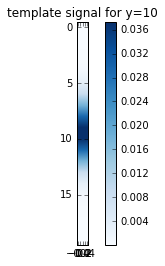

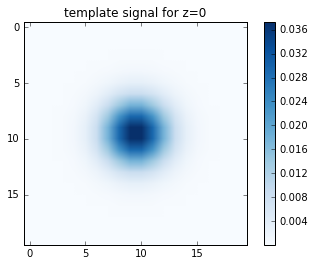

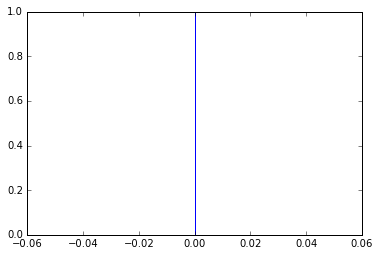

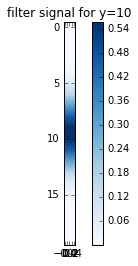

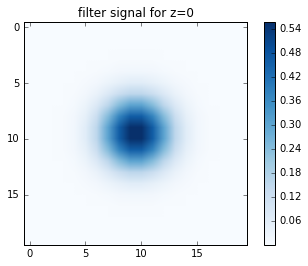

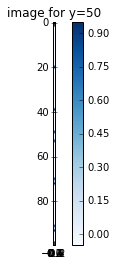

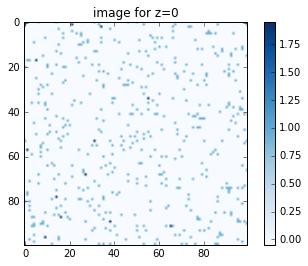

In [3]:
templatesize = 20 #in xy dimension
templateWidth = 2 #std of template gaussian in xy plane
timeLength = 1 #length of time dimension of template
decayTime = 1000
B = 0.05
Flux = 1

#generate normalized template
template, timefunction = makeTemplate(templatesize,timeLength, templateWidth, decayTime,1)

#draw template
make2Dsliceplot(template,'y',int(templatesize/2),'template signal',"Blues")
make2Dsliceplot(template,'z',int(timeLength/2),'template signal',"Blues")

#draw the "time" function
plt.plot(timefunction[0],timefunction[1])
plt.show()

#create the filter
filter = filterTemplate(template,B,Flux)
#draw the filter
make2Dsliceplot(filter,'y',int(templatesize/2),'filter signal',"Blues")
make2Dsliceplot(filter,'z',int(timeLength/2),'filter signal',"Blues")

#make mean subtracted background image
img = makeImage(B, templatesize*5,1)
#draw image
make2Dsliceplot(img,'y',int(templatesize*5/2),'image',"Blues")
#make2Dsliceplot(img,'z',int(timeLength*5/2),'image',"Blues")
make2Dsliceplot(img,'z',0,'image',"Blues")

In [6]:
beta = 0.001
templatesize = 10 #in xy dimension
templateWidth = 2 #std of template gaussian in xy plane
timeLength = 1 #length of time dimension of template
decayTime = 1000 
imageSizeXY = 2000
imageSizeT = 1

template, timefunction = makeTemplate(templatesize,timeLength, templateWidth, decayTime,1)

B = 0.005
beta = 0.001

Fth = initialFlux(B,templateWidth,beta)

initialFth = Fth
nIterations = 0
converged = False

import datetime
starttime = datetime.datetime.now()
print 'starting correlation '+str(starttime)


while(not converged):
    nIterations+=1
    
    print 'iteration: ',nIterations
    print 'Fth ',Fth
    
    filter = filterTemplate(template,B,Fth)
    
    Sf = fluxNormalisation(Fth, template, filter, B)
    print 'Sf ',Sf
    
    #generate image
    img = makeImage(B, imageSizeXY,imageSizeT)
    
    mf=signal.correlate(img,filter,'same')
    

    Sthreshold = np.percentile(mf.flatten(),(1-beta)*100.0)
    
    newFth = Sthreshold/Sf+B
    
    if(abs(newFth-Fth) < 0.01*Fth ):
        converged = True
    Fth = newFth

endtime = datetime.datetime.now()
print 'done : '+str(endtime-starttime)

print '\nThreshold S', Sthreshold
print 'inital Fth ', initialFth
print 'final Fth ', Fth

starting correlation 2017-09-13 21:55:49.984986
iteration:  1
Fth  2.002002002
Sf  2.06887015624
iteration:  2
Fth  2.7712450408
Sf  2.34795765307
done : 0:00:20.314710

Threshold S 6.48091791468
inital Fth  2.002002002
final Fth  2.76523628715


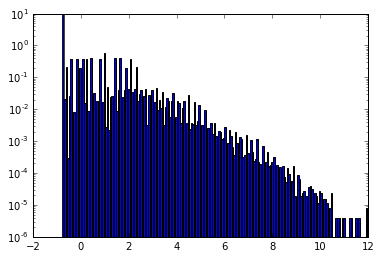

In [7]:
count, bins, ignored = plt.hist(mf.flatten(),200, normed=True)

plt.yscale('log', nonposy='clip')
plt.show()


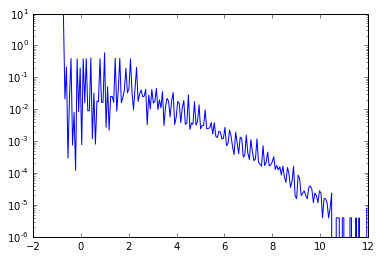

In [8]:
bincenters = 0.5*(bins[1:]+bins[:-1])

plt.plot(bincenters,count,'-')
plt.yscale('log', nonposy='clip')
plt.show()